### Downloading libraries

In [3]:
# install torch libraries
!pip3 install torch

In [31]:
# install torch vision libraries (utilities to train neural networks)
!pip3 install torchvision

### Importing libraries

In [5]:
import pandas as pd

import matplotlib.pyplot as plt

### Loading dataset

In [6]:
advertising_data = pd.read_csv('datasets/Advertising.csv', index_col=0)

advertising_data.sample(10)

,TV,radio,newspaper,sales
199,283.6,42.0,66.2,25.5
179,276.7,2.3,23.7,11.8
198,177.0,9.3,6.4,12.8
62,261.3,42.7,54.7,24.2
42,177.0,33.4,38.7,17.1
58,136.2,19.2,16.6,13.2
156,4.1,11.6,5.7,3.2
11,66.1,5.8,24.2,8.6
45,25.1,25.7,43.3,8.5
149,38.0,40.3,11.9,10.9


In [7]:
advertising_data.shape

(200, 4)

### Scaling the continuous values

In [8]:
from sklearn import preprocessing

In [9]:
advertising_data[['TV']] = preprocessing.scale(advertising_data[['TV']])
advertising_data[['radio']] = preprocessing.scale(advertising_data[['radio']])
advertising_data[['newspaper']] = preprocessing.scale(advertising_data[['newspaper']])

In [10]:
advertising_data.sample(10)

,TV,radio,newspaper,sales
19,-0.908957,-0.186635,-0.564074,11.3
130,-1.021055,-0.760585,0.577515,9.7
118,-0.824884,-1.516849,-0.725185,9.4
98,0.442057,-0.152873,-0.393756,15.5
58,-0.126607,-0.274416,-0.642328,13.2
13,-1.439088,0.799209,1.627040,9.2
21,0.833233,0.299535,1.051643,18.0
164,0.192172,0.913999,-1.065821,18.0
30,-0.892610,-0.490491,0.471642,10.5
146,-0.078731,-1.442573,-0.992170,10.3


In [11]:
X = advertising_data.drop('sales', axis=1)

Y = advertising_data[['sales']]

#### Split the data into two chunks - 80% for training and 20% for testing 

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [13]:
x_train.shape, y_train.shape

((160, 3), (160, 1))

In [14]:
x_test.shape, y_test.shape

((40, 3), (40, 1))

#### Converting data in pytorch tensors

In [15]:
import torch

In [16]:
x_train_tensor = torch.tensor(x_train.values, dtype = torch.float)
x_test_tensor = torch.tensor(x_test.values, dtype = torch.float)

y_train_tensor = torch.tensor(y_train.values, dtype = torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float)

In [17]:
x_train_tensor.shape, y_train_tensor.shape

(torch.Size([160, 3]), torch.Size([160, 1]))

In [18]:
x_test_tensor.shape, y_test_tensor.shape

(torch.Size([40, 3]), torch.Size([40, 1]))

#### Define the parameters for the neural network
* <b>inp</b> sets the input size to 26 to match the shape of the X_train_tensor. With the one-hot-encoding, we have multiple columns in our X data
* <b>out</b> will be used to set the size of the output from the neural network. We only predict a single price for each car, so this will be 1
* <b>hid</b> is used to set the number of hidden layers in our neural network
* <b>loss_fn</b> is MSELoss since we're performing a linear regression
* <b>learning_rate</b> is set to 0.0001

In [19]:
inp = 3
out = 1

hid = 100

loss_fn = torch.nn.MSELoss()

learning_rate = 0.0001

<b>nn.Sequential:</b>
Use the nn package to define our model as a sequence of layers. nn.Sequential is a Module which contains other Modules, and applies them in sequence to produce its output. Each Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.

<b>nn.Linear: </b> Applies a linear transformation to the incoming data: y=Ax+b<br>
parameters:<br>
in_features – size of each input sample
out_features – size of each output sample
bias – If set to False, the layer will not learn an additive bias. Default: True

<b>Sigmoid : </b>Applies the element-wise function Sigmoid(x)= 1 / (1+exp(−x))

#### Creating model using nn.Sequential( )

In [20]:
model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
                            torch.nn.ReLU(),
                            torch.nn.Linear(hid, out))

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##### Training Model
Foward Pass:
* Predicting Y with input data X

Finding Loss:
* Finding difference between Y_train_tensor and Y_pred using MSEloss function defined above


Back Propogation:
* starting with zero gradients before back propogation
* back propogation is done by simply loss.backward() function

Manually updating model parameters
* weights have requires_grad=True, but we don't need to track this in autograd. So will wrap it in torch.no_grad
* model.parameter() returns all the weights and biases of parameters
* reducing weight with multiple of learning rate and gradient

In [22]:
for iter in range(10000):
    
    y_pred = model(x_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)

    if iter % 1000 ==0:
        print(iter, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step() ## update model parameters

0 226.8085479736328
1000 124.89188385009766
2000 34.2551155090332
3000 8.622419357299805
4000 6.280181884765625
5000 4.867207050323486
6000 3.5190467834472656
7000 2.3646998405456543
8000 1.5274021625518799
9000 0.9980166554450989


#### Using our model for predictions
We pick one of the ads from the test data set for prediction of sale

In [23]:
sample = x_test.iloc[14]
sample

TV          -0.824884
radio        0.232011
newspaper   -0.379947
Name: 81, dtype: float64

#### We convert these features to a Pytorch tensor

In [24]:
sample_tensor = torch.tensor(sample.values, 
                             dtype = torch.float)
sample_tensor

tensor([-0.8249,  0.2320, -0.3799])

#### Compare the actual and predicted sale
The predicted sale is very close to its actual sale

In [25]:
y_pred = model(sample_tensor)

print("Predicted sale : ", int(y_pred.item()))
print("Actual sale : ", int(y_test.iloc[23]))

Predicted sale :  10
Actual sale :  12


#### Performing predictions on the entire test set
We get the list of predicted values in a tensor

In [26]:
y_pred_tensor = model(x_test_tensor)

y_pred_tensor[:5]

tensor([[ 9.6573],
        [ 8.2963],
        [ 8.9577],
        [25.8490],
        [11.7454]], grad_fn=<SliceBackward>)

#### The tensor is converted to a numpy array

In [27]:
y_pred = y_pred_tensor.detach().numpy()

y_pred[:5]

array([[ 9.657308],
       [ 8.296314],
       [ 8.95765 ],
       [25.848991],
       [11.745406]], dtype=float32)

#### Plot a graph of the predicted values against the actual ones 
The good news is there appears to be a strong positive correlation 

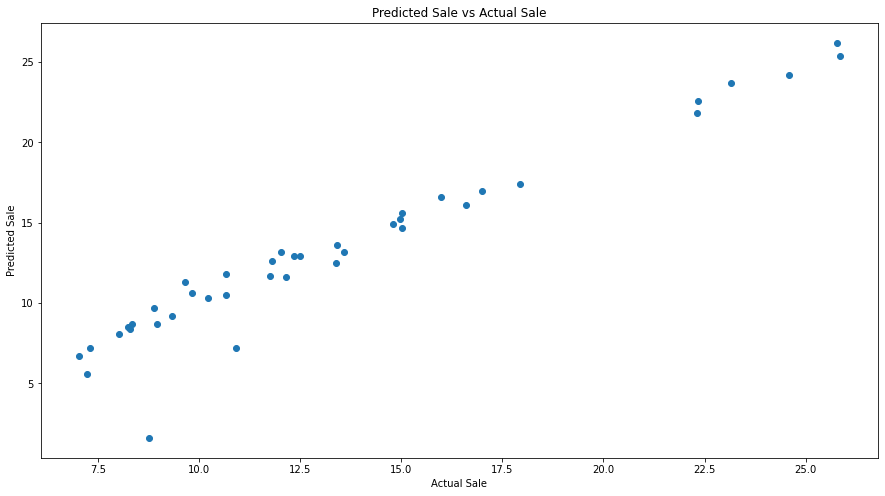

In [28]:
plt.figure(figsize=(15, 8))

plt.scatter(y_pred, y_test.values)

plt.xlabel("Actual Sale")
plt.ylabel("Predicted Sale")

plt.title("Predicted Sale vs Actual Sale")
plt.show()

In [29]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.936430607550347

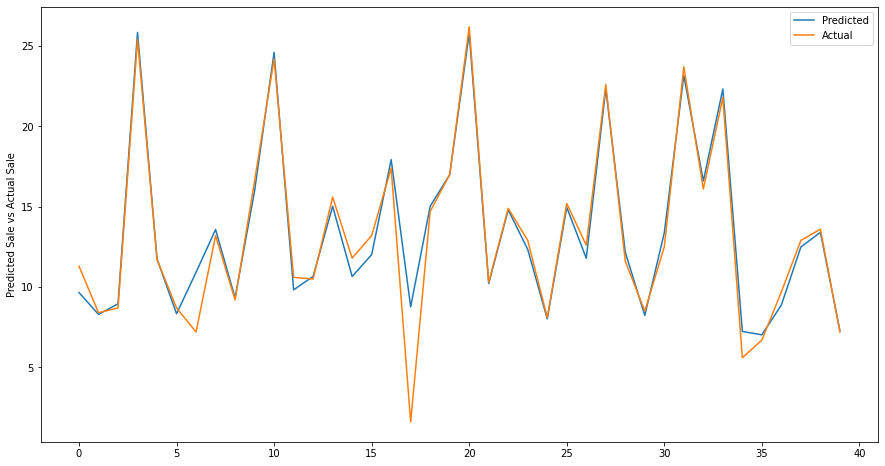

In [32]:
plt.figure(figsize = (15, 8))

plt.plot(y_pred, label='Predicted')
plt.plot(y_test.values, label='Actual')

plt.ylabel("Predicted Sale vs Actual Sale")
plt.legend()
plt.show()